In [6]:
# Plotting and environment setup for IPython

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, sys, numpy , pylab
import seaborn as sns
import warnings

# --- Style setup ---
colors = ["#3690c8", "#f8db37", "ebab78", "e4607b", "f2efed", "#8fb5c7", "#352c30", "#c0d3e0", "#eddab1", "#d99fad"]

sns.set_context('talk') 
sns.set_theme(font_scale=1.2)
sns.set_palette('colorblind')
sns.set_style('ticks')

pylab.rcParams.update({
    'text.usetex': False,
    'font.family': 'stixgeneral',
    'mathtext.fontset': 'stix',
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.color': '#ececec',
    'axes.linewidth': 1,
    'axes.prop_cycle': pylab.cycler(color=colors),
})

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# --- Manually source lalsuiterc ---
def source_lalsuiterc(filepath):
    if not os.path.isfile(filepath):
        print(f"⚠️ lalsuiterc not found at {filepath}")
        return
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#') or not line.startswith('export'):
                continue
            try:
                key, val = line.replace('export ', '').split('=', 1)
                val = val.strip('"').replace('$PWD', os.getcwd())
                val = os.path.expandvars(val)
                os.environ[key.strip()] = val
            except Exception as e:
                print(f"❌ Failed to parse line: {line} — {e}")

lalsuiterc_path = "/home/rossella.gamba/src/lalsuite-param-teob/_inst/etc/lalsuiterc"
source_lalsuiterc(lalsuiterc_path)

# --- Manually append to PYTHONPATH and sys.path ---
def append_path(path):
    if os.path.isdir(path):
        if path not in sys.path:
            sys.path.insert(0, path)
        existing = os.environ.get("PYTHONPATH", "")
        paths = existing.split(':') if existing else []
        if path not in paths:
            paths.insert(0, path)
            os.environ["PYTHONPATH"] = ':'.join(paths)

# Add site-packages path
pyver = f"{sys.version_info.major}.{sys.version_info.minor}"
site_pkg = f"/home/rossella.gamba/src/lalsuite-param-teob/_inst/lib/python{pyver}/site-packages"
append_path(site_pkg)

# Add Python source dir
src_path = "/home/rossella.gamba/src/lalsuite-param-teob/lalsimulation/python"
append_path(src_path)
gwsignal_path = "/home/rossella.gamba/src/lalsuite-param-teob/lalsimulation/python/lalsimulation"
append_path(gwsignal_path)

# --- Test imports ---
print("\n🔍 Import test:")
try:
    import gwsignal
    print("✅ Successfully imported gwsignal")
except ImportError as e:
    print("❌ Failed to import gwsignal:", e)

try:
    import lalsimulation
    print("✅ Successfully imported lalsimulation")
except ImportError as e:
    print("❌ Failed to import lalsimulation:", e)



🔍 Import test:
✅ Successfully imported gwsignal
✅ Successfully imported lalsimulation


In [7]:
def whitened_time_domain_strain(ifo):
    frequency_window_factor = (numpy.sum(ifo.frequency_mask) / len(ifo.frequency_mask))
    whitened_time_series = (numpy.fft.irfft(ifo.whitened_frequency_domain_strain) * 
                            numpy.sqrt(numpy.sum(ifo.frequency_mask)) / frequency_window_factor)
    return whitened_time_series

In [8]:
import bilby
from tqdm import tqdm
from copy import deepcopy

def plot_interferometer_waveform_or_residual_posterior(ifo, 
                                                       number_of_samples,
                                                       results, 
                                                       label,
                                                       level=0.9,
                                                       start_time=-0.4,
                                                       end_time=0.2,
                                                       residual='both'):  # now accepts 'both', True, or False

    posteriors = results.posterior
    posteriors.sort_values(by='L1_log_likelihood', ascending=False, inplace=True)
    maxl = numpy.argmax(posteriors['L1_log_likelihood'])
    start_time += posteriors['L1_time'].iloc[maxl]
    end_time += posteriors['L1_time'].iloc[maxl]

    time_indices = ((ifo.time_array >= start_time) & 
                    (ifo.time_array <= end_time))
    plot_times = ifo.time_array[time_indices]
    plot_times -= posteriors['L1_time'].iloc[maxl]  # Centering the plot around the maximum likelihood time  
    # ifo.strain_data.start_time
    # start_time -= ifo.strain_data.start_time
    # end_time -= ifo.strain_data.start_time

    waveform_generator = results.waveform_generator_class(duration = ifo.duration,
                                                          sampling_frequency=ifo.sampling_frequency,
                                                          frequency_domain_source_model = results.frequency_domain_source_model,
                                                          parameter_conversion=results.parameter_conversion,
                                                          waveform_arguments = results.waveform_arguments,)

    whitened_timeseries = deepcopy(whitened_time_domain_strain(ifo)[time_indices])

    whitened_waveforms = []
    whitened_residuals = []
    
    for k in track(range(number_of_samples)):
        params = posteriors.iloc[k].to_dict()
        waveform_polarisations = waveform_generator.frequency_domain_strain(params)
        frequency_domain_waveform = ifo.get_detector_response(waveform_polarisations, params)
        whitened_frequency_domain_waveform = frequency_domain_waveform / (ifo.amplitude_spectral_density_array * numpy.sqrt(ifo.duration / 4))

        frequency_window_factor = (numpy.sum(ifo.frequency_mask) / len(ifo.frequency_mask))
        whitened_time_domain_waveform = (numpy.fft.irfft(whitened_frequency_domain_waveform) * 
                                         numpy.sqrt(numpy.sum(ifo.frequency_mask)) / frequency_window_factor)
        
        whitened_waveforms.append(whitened_time_domain_waveform[time_indices])
        whitened_residuals.append(whitened_timeseries - whitened_time_domain_waveform[time_indices])

    whitened_waveforms = numpy.asarray(whitened_waveforms)
    whitened_residuals = numpy.asarray(whitened_residuals)

    delta = (1 + level)/2
    upper_percentile = delta * 100
    lower_percentile = (1 - delta) * 100

    if residual == 'both':
        fig, axs = pylab.subplots(2, 1, figsize=(15, 6), sharex=True)

        # Waveform Posterior
        axs[0].plot(plot_times, whitened_timeseries, alpha=0.3, label='Whitened Data', color=colors[0])
        axs[0].plot(plot_times, numpy.mean(whitened_waveforms, axis=0), label='Mean reconstructed', color=colors[1])
        axs[0].fill_between(plot_times, numpy.percentile(whitened_waveforms, lower_percentile, axis=0),
                            numpy.percentile(whitened_waveforms, upper_percentile, axis=0), alpha=0.3, color=colors[1])
        axs[0].set_ylabel(r'$\sigma_{\rm noise}$')
        axs[0].legend()
        axs[0].set_title(f'{label} - Waveform Posterior')

        # Residuals
        axs[1].plot(plot_times, numpy.mean(whitened_residuals, axis=0), label='Mean residual', color=colors[1])
        axs[1].fill_between(plot_times, numpy.percentile(whitened_residuals, lower_percentile, axis=0),
                            numpy.percentile(whitened_residuals, upper_percentile, axis=0), alpha=0.3, color=colors[1])
        axs[1].set_xlabel(r'$t-t_{\rm L1}$ (s)')
        axs[1].set_ylabel(r'$\sigma_{\rm noise}$')
        axs[1].legend()
        axs[1].set_title(f'{label} - Residual')

        pylab.tight_layout()
        # pylab.savefig(f'{output_directory}/{results.label}-combined.pdf', bbox_inches='tight')

    elif residual is True:
        pylab.figure(figsize=(15,3))
        pylab.plot(plot_times, numpy.mean(whitened_residuals, axis=0), label='Mean residual', color=colors[1])
        pylab.fill_between(plot_times, numpy.percentile(whitened_residuals, lower_percentile, axis=0),
                           numpy.percentile(whitened_residuals, upper_percentile, axis=0), alpha=0.3, color=colors[1])
        pylab.xlabel(r'$t_{\rm geo}$ (s)')
        pylab.ylabel(r'$\sigma_{\rm noise}$')
        pylab.legend()
        pylab.title(f'{label} - Residual')
        # pylab.savefig(f'{output_directory}/{results.label}-residual.pdf', bbox_inches='tight')

    else:
        pylab.figure(figsize=(15,3))
        pylab.plot(plot_times, whitened_timeseries, alpha=0.3, label='Whitened Data', color=colors[0])
        pylab.plot(plot_times, numpy.mean(whitened_waveforms, axis=0), label='Mean reconstructed', color=colors[1])
        pylab.fill_between(plot_times, numpy.percentile(whitened_waveforms, lower_percentile, axis=0),
                           numpy.percentile(whitened_waveforms, upper_percentile, axis=0), alpha=0.3, color=colors[1])
        pylab.xlabel(r'$t_{\rm geo}$ (s)')
        pylab.ylabel(r'$\sigma_{\rm noise}$')
        pylab.legend()
        pylab.title(f'{label} - Waveform Posterior')
        # pylab.savefig(f'{output_directory}/{results.label}.pdf', bbox_inches='tight')
    
    return {
        'plot_times': plot_times,
        'whitened_data': whitened_timeseries,
        'mean_residual': numpy.mean(whitened_waveforms, axis=0),
        'residuals': numpy.asarray(whitened_waveforms),
        'confidence': level
    }

In [9]:

sampling_frequency = 4096 # Hz
maximum_frequency = 800
minimum_frequency = {'H1': 20, 'L1': 20} # Hz
duration = 8
post_merger_duration = 2
trigger_time = 1420878141.222656 #s 
end_time = int(trigger_time + post_merger_duration)
start_time = int(end_time - duration)

psds = { 'H1' : '/home/koustav.chandra/projects/o4/s250114ax/psds/estimate-using-bayeswave/trigtime_1420878141.2226562_0.0_0.0_0-16s/post/glitch/glitch_median_PSD_forLI_H1.dat',
                   'L1' : '/home/koustav.chandra/projects/o4/s250114ax/psds/estimate-using-bayeswave/trigtime_1420878141.2226562_0.0_0.0_0-16s/post/glitch/glitch_median_PSD_forLI_L1.dat'}

frames = {'H1' : '/home/koustav.chandra/projects/o4/s250114ax/frames/H-H1_HOFT_C00_AR-1420878111-50.gwf', 
          'L1': '/home/koustav.chandra/projects/o4/s250114ax/frames/L-L1_HOFT_C00_AR-1420878111-50.gwf'}
data_format = None

channels = {'H1' : 'H1:GDS-CALIB_STRAIN_CLEAN_AR',
            'L1' : 'L1:GDS-CALIB_STRAIN_CLEAN_AR'}

spline_calibration_envelope_dict = {'H1': '/home/koustav.chandra/projects/o4/s250114ax/calibration/calibration_uncertainty_H1_1420876818.txt', 
                                    'L1': '/home/koustav.chandra/projects/o4/s250114ax/calibration/calibration_uncertainty_L1_1420876818.txt'}

In [10]:
ifos = bilby.gw.detector.InterferometerList([])
colors = {'H1': '#ca2000', 'L1': '#0571b0', 'V1': '#171717'}

for detector in ['H1', 'L1']:
    ifo = bilby.gw.detector.get_empty_interferometer(detector)

    ifo.set_strain_data_from_frame_file(
        frame_file=frames[detector],
        channel=channels[detector],
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=start_time,
    )
    ifo.minimum_frequency = minimum_frequency[detector]
    ifo.maximum_frequency = maximum_frequency

    data = numpy.genfromtxt(fname=psds[ifo.name])
    frequency_array, psd_array = data[:, 0], data[:, 1]
    valid = (frequency_array > ifo.minimum_frequency) & (frequency_array < ifo.maximum_frequency)

    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=frequency_array[valid],
        psd_array=psd_array[valid]
    )

    # Whitened time-domain strain
    whitened_strain = (1. / (4. * numpy.pi * ifo.duration)) * bilby.core.utils.infft(
        ifo.whitened_frequency_domain_strain,
        sampling_frequency=ifo.strain_data.sampling_frequency
    )
    
    ifo.calibration_model = bilby.gw.detector.calibration.CubicSpline(
        prefix=f"recalib_{ifo.name}_",
        minimum_frequency=ifo.minimum_frequency,
        maximum_frequency=ifo.maximum_frequency,
        n_points=10,
    )
    # Append to list
    ifos.append(ifo)

19:40 bilby INFO    : Reading data from frame file /home/koustav.chandra/projects/o4/s250114ax/frames/H-H1_HOFT_C00_AR-1420878111-50.gwf
19:40 bilby INFO    : Successfully loaded H1:GDS-CALIB_STRAIN_CLEAN_AR.
19:40 bilby INFO    : Reading data from frame file /home/koustav.chandra/projects/o4/s250114ax/frames/L-L1_HOFT_C00_AR-1420878111-50.gwf
19:40 bilby INFO    : Successfully loaded L1:GDS-CALIB_STRAIN_CLEAN_AR.


In [11]:
import bilby
from pesummary.core.plots.publication import triangle_plot
from pesummary.utils.bounded_1d_kde import bounded_1d_kde
from pesummary.utils.bounded_2d_kde import Bounded_2d_kde
from pesummary.gw.plots.latex_labels import public_GWlatex_labels, GWlatex_labels
from pesummary.utils.array import Array
def plot_triangle_with_posteriors(posteriors, parameters, 
                                  colors=colors,
                                  show_median_estimates=True, 
                                  position=None,
                                  show_maximum_likelihood=True):
    x, y = posteriors[parameters[0]], posteriors[parameters[1]]
    x_label, y_label = GWlatex_labels[parameters[0]], GWlatex_labels[parameters[1]]
    figure, ax1, ax2, ax3 = triangle_plot(
        x=x,
        y=y,
        kde=bounded_1d_kde,
        kde_2d=Bounded_2d_kde,
        xlabel=x_label,
        ylabel=y_label,
        colors=['#ca2000'],
    )
    ax2.grid(linestyle=':', color='#171717')
    if show_maximum_likelihood:
        maxl = numpy.argmax(posteriors['log_likelihood'])
        maxl_x, maxl_y = x[maxl], y[maxl]
        ax2.scatter(maxl_x, maxl_y, color='gold', edgecolor='#171717',
                    label=fr'MaxL:{x_label}={round(maxl_x, 2)}~{y_label}={round(maxl_y, 2)}',
                    zorder=5, s=100, marker = '*',
                    )
    if show_median_estimates:
        text_str = ""
        for variable, label in zip((x, y), (x_label, y_label)):
            array = Array(variable)
            median = array.average(type='median')
            confidence_interval = array.confidence_interval(percentile=[5, 95])
            l=fr'{label}=${numpy.round(median, 2)}^{{+{numpy.round(confidence_interval[-1]-median, 2)}}}_{{{numpy.round(confidence_interval[0]-median, 2)}}}$'
            text_str += l + '\n'
        if not position:
            ax2.text(0.05, 0.05, text_str, transform=ax2.transAxes, fontsize=12,
                    verticalalignment='bottom', bbox=dict(facecolor='white', boxstyle='round', edgecolor='#171717'))
        else:
            ax2.text(0.5, 0.5, text_str, transform=ax2.transAxes, fontsize=12,
                    verticalalignment=position, bbox=dict(facecolor='white', boxstyle='round', edgecolor='#171717'))

    ax2.legend(loc='lower right')
    return figure, ax1, ax2, ax3

/home/rossella.gamba/.conda/envs/lalsuite-param-teob/lib/python3.9/site-packages/pesummary/utils/decorators.py:288: UserWarning: The Array.confidence_interval method will be deprecated in future releases. Please use Array.credible_interval instead
  warnings.warn(warning)


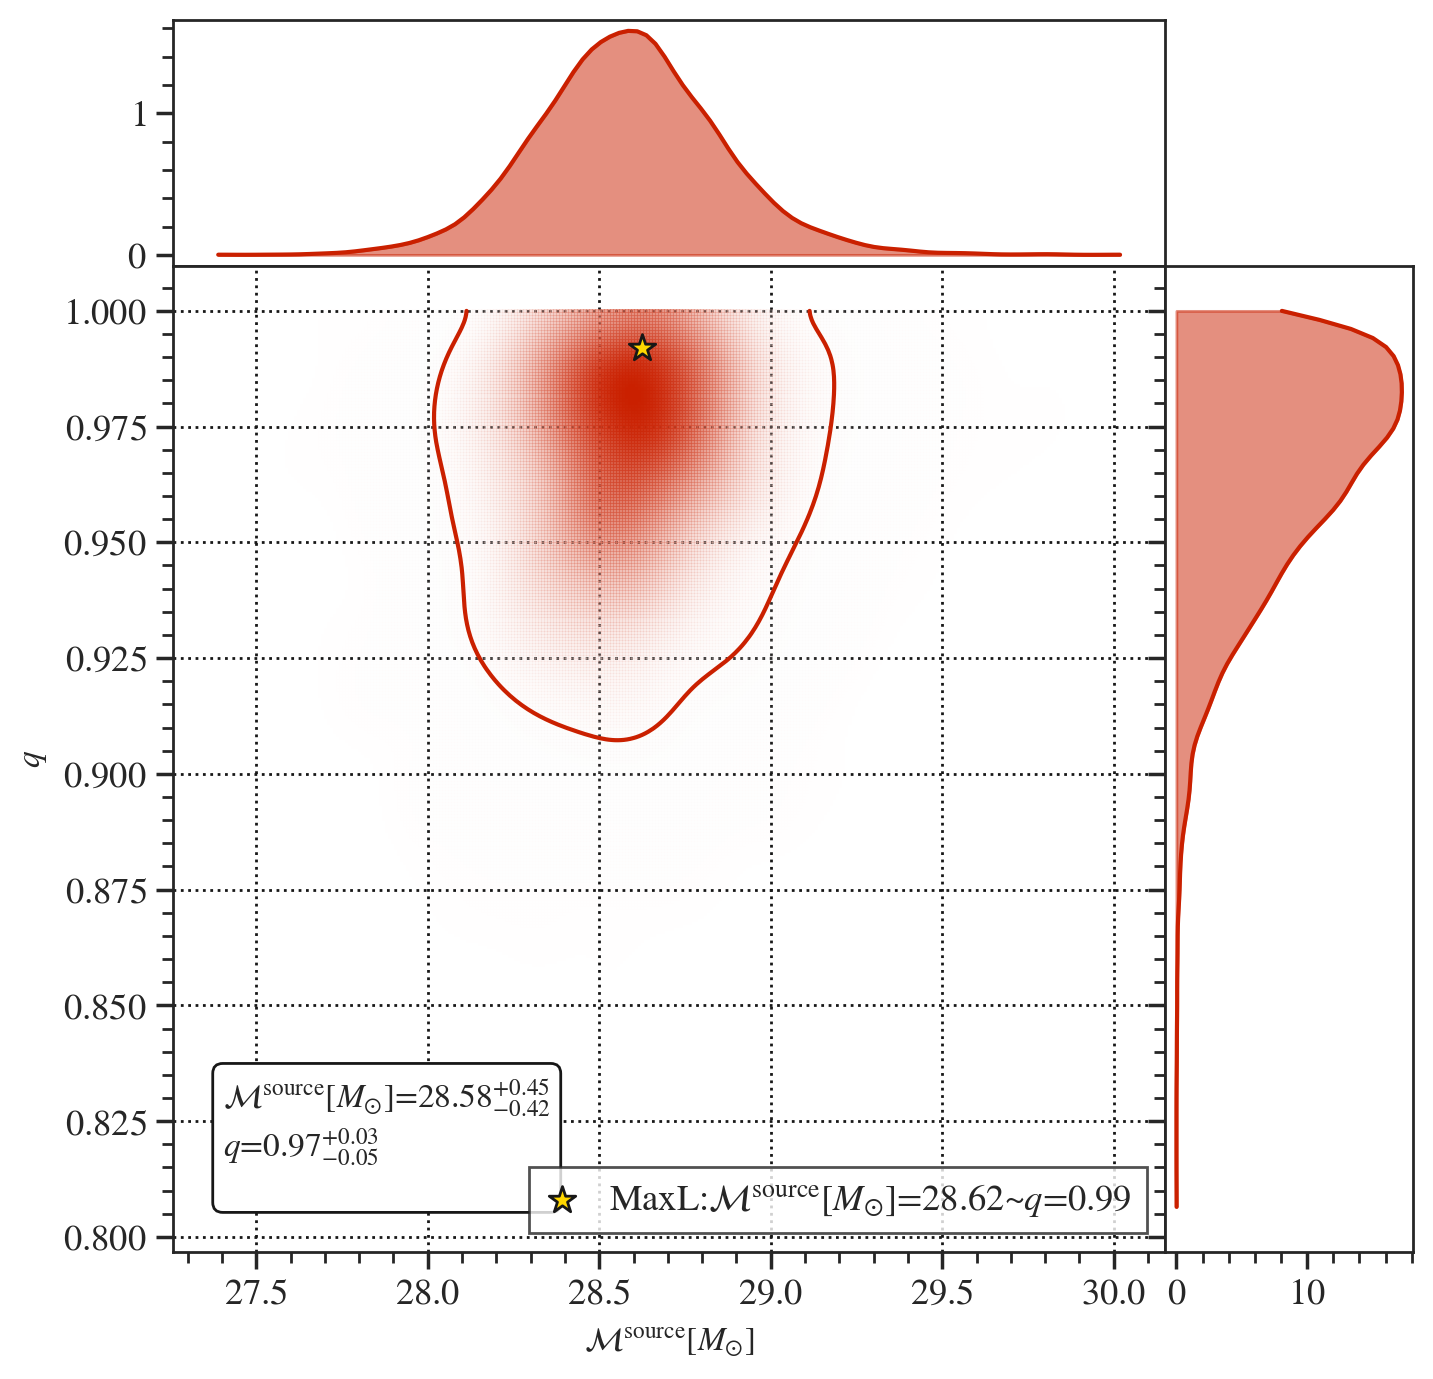

In [12]:
results = bilby.gw.result.CBCResult.from_json('/home/rossella.gamba/projects/teob-parametrized/pe/GW250114ax/eccentric-aligned/result/teobresums-non-eccentric-aligned_data0_1420878141-222656_analysis_H1L1_par2_result.json')
posteriors = results.posterior
figure, ax1, ax2, ax3 = plot_triangle_with_posteriors(posteriors=posteriors,
                                                      parameters=['chirp_mass_source', 'mass_ratio'])

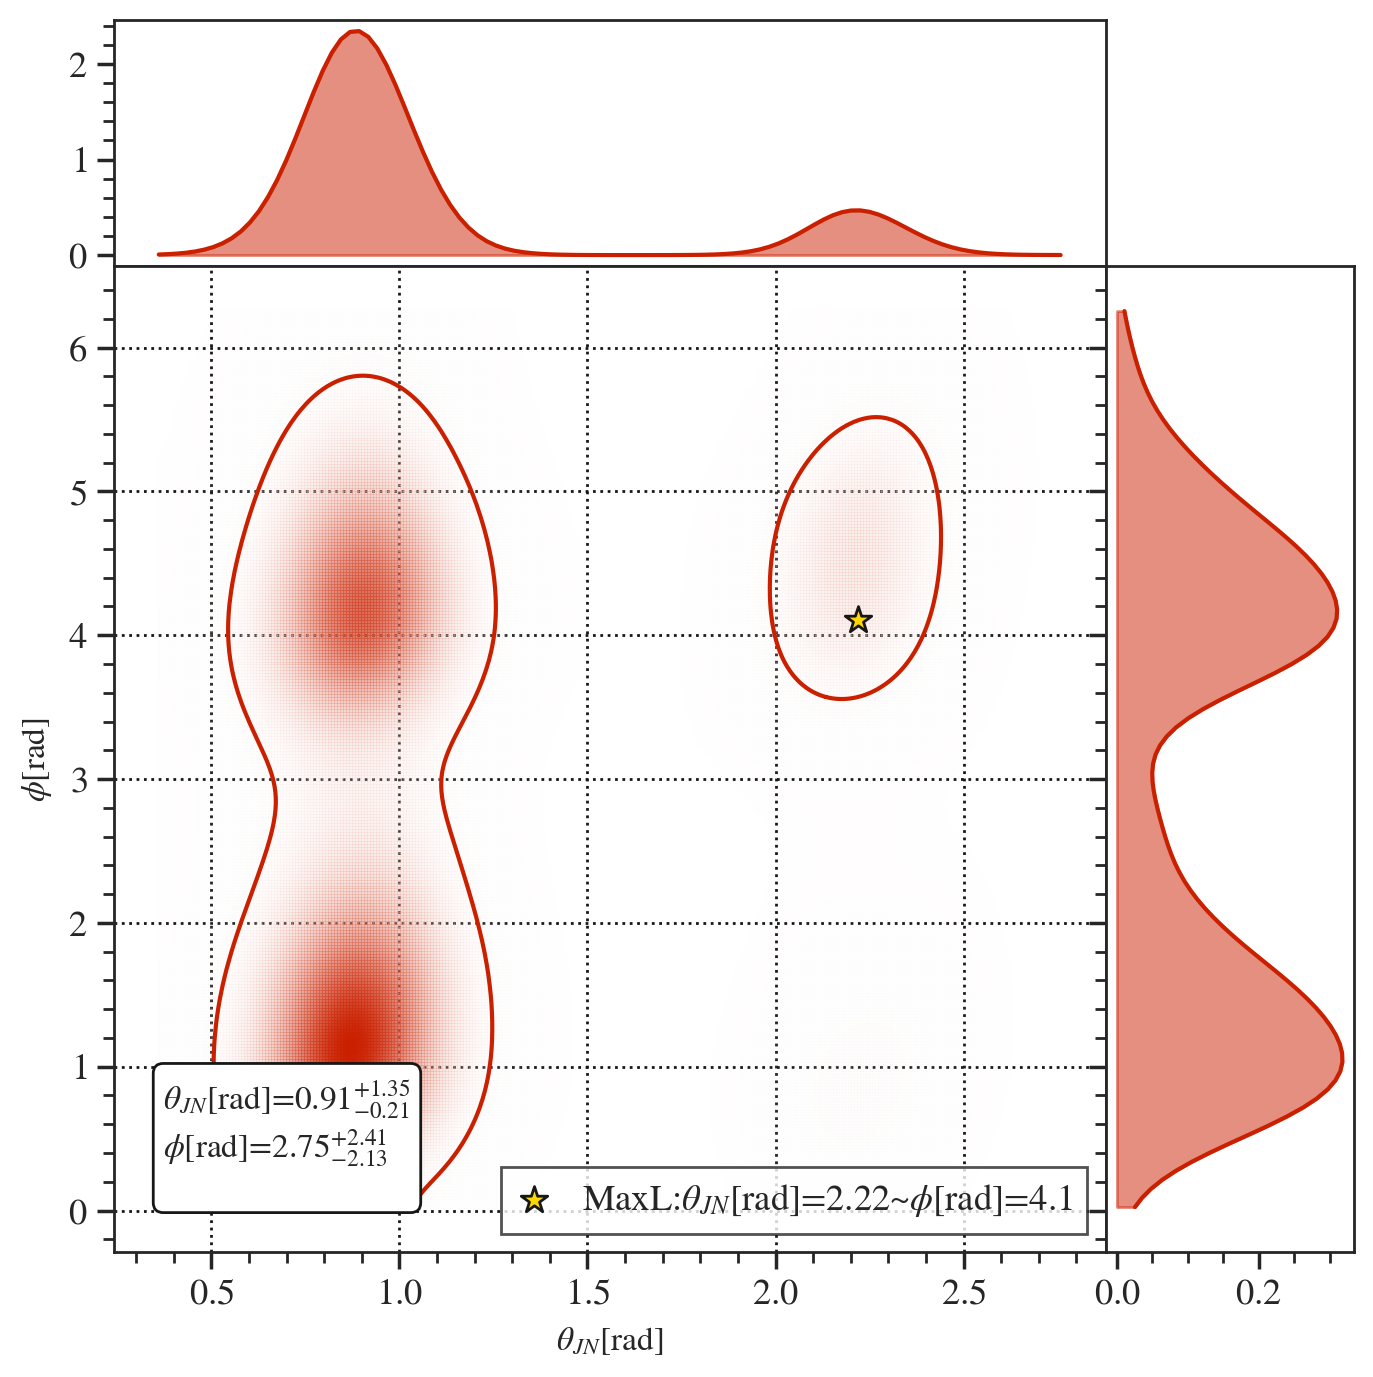

In [13]:
figure, ax1, ax2, ax3 = plot_triangle_with_posteriors(posteriors=posteriors,
                                                      parameters=['theta_jn', 'phase'])

In [19]:
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_snr_for_mode(mode_array, posterior, results, ifos, number_of_samples, waveform_approximant=None):
    waveform_arguments = results.waveform_arguments.copy()
    waveform_arguments['mode_array'] = mode_array
    
    try:
        waveform_generator = results.waveform_generator_class(
            duration=results.duration,
            sampling_frequency=results.sampling_frequency,
            frequency_domain_source_model=results.frequency_domain_source_model,
            parameter_conversion=results.parameter_conversion,
            waveform_arguments=waveform_arguments,
        )

        snr_values = []
        for k in range(number_of_samples):
            parameters = posterior.iloc[k].to_dict()
            waveform_polarisations = waveform_generator.frequency_domain_strain(parameters=parameters)
            o = 0
            for ifo in ifos:
                signal_ifo = ifo.get_detector_response(waveform_polarisations, parameters)
                o += ifo.optimal_snr_squared(signal_ifo)
            snr_values.append(o)

        return (str(mode_array), snr_values)
    except:
        if waveform_approximant is not None:
            waveform_arguments['waveform_approximant'] = waveform_approximant
            frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole
        else:
            waveform_arguments['waveform_approximant'] = results.waveform_arguments['waveform_approximant']
            frequency_domain_source_model = results.frequency_domain_source_model
        waveform_generator = results.waveform_generator_class(
            duration=results.duration,
            sampling_frequency=results.sampling_frequency,
            frequency_domain_source_model=results.frequency_domain_source_model,
            parameter_conversion=results.parameter_conversion,
            waveform_arguments=waveform_arguments,
        )

        snr_values = []
        for k in range(number_of_samples):
            parameters = posterior.iloc[k].to_dict()
            waveform_polarisations = waveform_generator.frequency_domain_strain(parameters=parameters)
            o = 0
            for ifo in ifos:
                signal_ifo = ifo.get_detector_response(waveform_polarisations, parameters)
                o += ifo.optimal_snr_squared(signal_ifo)
            snr_values.append(o)

        return (str(mode_array), snr_values)



def get_mode_by_mode_snr_parallel_over_modes(ifos, number_of_samples, results, num_jobs=10, waveform_approximant=None):
    posterior = results.posterior
    mode_arrays = [[(2, 2)], [(2, 1)],[(3, 3)], [(4, 4)]] #[[(2,2), (2,-2)], [(3,3), (3,-3)], [(2,1), (2,-1)], [(4,4), (4,-4)],]
    if waveform_approximant is not None:
        results_list = Parallel(n_jobs=num_jobs)(
            delayed(compute_snr_for_mode)(mode_array, posterior, results, ifos, number_of_samples, waveform_approximant)
            for mode_array in mode_arrays
        )
    else:
        results_list = Parallel(n_jobs=num_jobs)(
            delayed(compute_snr_for_mode)(mode_array, posterior, results, ifos, number_of_samples)
            for mode_array in mode_arrays
        )

    return dict(results_list)


In [ ]:
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from scipy.stats import chi
def get_mode_by_mode_optimal_snr_plot(optimal_snr_squared):
    # Optional: Sort keys to ensure consistent order
    keys = sorted(optimal_snr_squared.keys())

    # Set up subplots
    num_modes = len(keys)
    ncols = 2
    nrows = (num_modes + 1) // ncols

    pylab.figure(figsize=(6 * ncols, 4 * nrows), dpi=100)

    for idx, key in enumerate(keys):
        snrsq = numpy.sqrt(numpy.real(optimal_snr_squared[key]))
        
        # KDE
        kde = bounded_1d_kde(snrsq, xlow=min(snrsq), xhigh=max(snrsq), method="Reflection")
        x_vals = numpy.linspace(min(snrsq), max(snrsq), 500)
        y_vals = kde(x_vals)

        # Fit chi distribution
        # chi.fit returns (df, loc, scale)
        dof, loc, scale = chi.fit(snrsq, floc=0)  # Fix location to 0 for reduced chi^2

        # Plotting
        ax = pylab.subplot(nrows, ncols, idx + 1)
        ax.plot(x_vals, y_vals,)

        chi_pdf = chi.pdf(x_vals, df=2, loc=loc, scale=scale)
        ax.plot(x_vals, chi_pdf, 'r--', label='Chi PDF')

        ax.set_title(f'Mode {key}', fontsize=10)
        ax.set_xlabel(r'$\rho_{opt}$')
        ax.set_ylabel('Density')
        ax.grid(True)
        ax.legend()

    pylab.tight_layout()
    pass


In [20]:
bilby.core.utils.setup_logger(log_level='ERROR')
optimal_snr_squared = get_mode_by_mode_snr_parallel_over_modes(ifos, 5000, results)
get_mode_by_mode_optimal_snr_plot(optimal_snr_squared)

19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_

NameError: name 'get_mode_by_mode_optimal_snr_plot' is not defined

/home/rossella.gamba/.conda/envs/lalsuite-param-teob/lib/python3.9/site-packages/pesummary/utils/decorators.py:288: UserWarning: pesummary.core.plots.bounded_1d_kde.bounded_1d_kde has changed to pesummary.utils.bounded_1d_kde.bounded_1d_kde. This may not be supported in future releases. Please update.
  warnings.warn(warning)


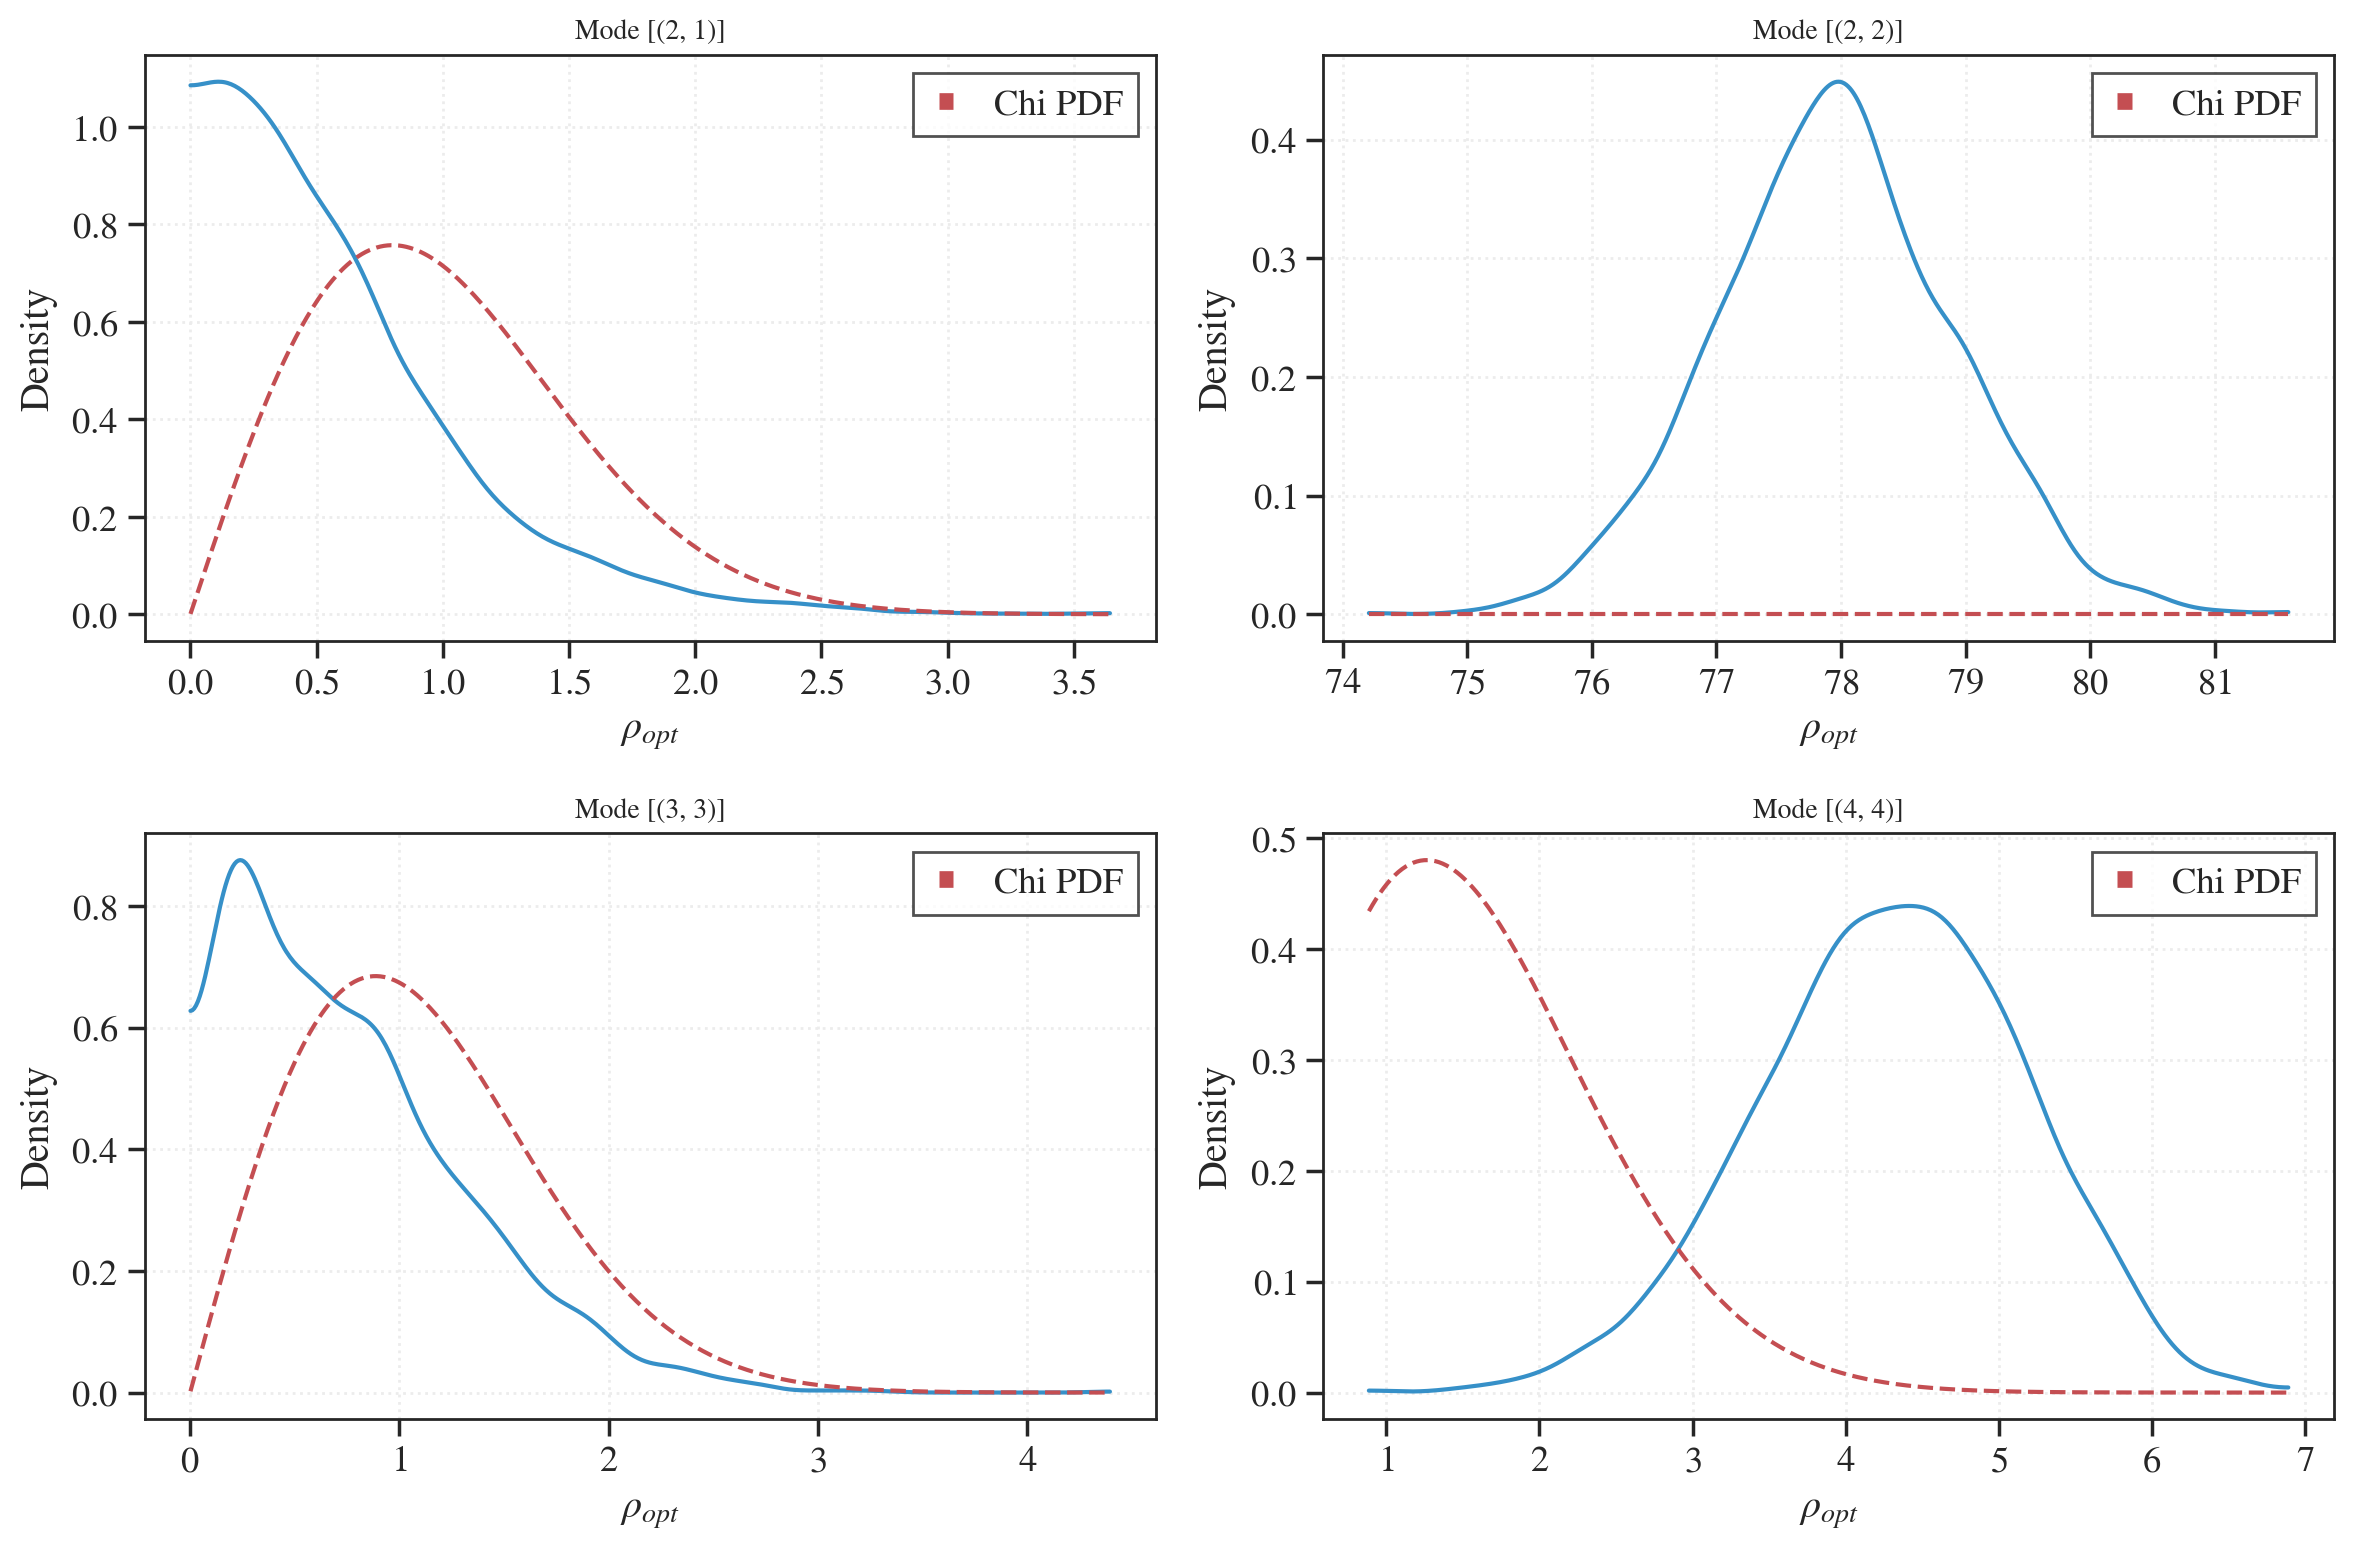

In [22]:
get_mode_by_mode_optimal_snr_plot(optimal_snr_squared)

In [23]:
def get_90CI(optimal_snr_squared, mode):
    """
    Calculate the 90% credible interval for the optimal SNR squared for a given mode.
    """
    snr_values = numpy.sqrt(numpy.real(optimal_snr_squared[mode]))
    lower_bound = numpy.percentile(snr_values, 5)
    upper_bound = numpy.percentile(snr_values, 95)
    median = numpy.median(snr_values)
    return lower_bound, upper_bound, median


for mode in optimal_snr_squared.keys():
    lower_bound, upper_bound, median = get_90CI(optimal_snr_squared, mode)
    print(f"Mode {mode}: 90% CI = ({median:.2f}, {(lower_bound-median):.2f}, {(upper_bound-median):.2f})")    

Mode [(2, 2)]: 90% CI = (77.95, -1.57, 1.59)
Mode [(2, 1)]: 90% CI = (0.48, -0.44, 1.10)
Mode [(3, 3)]: 90% CI = (0.66, -0.56, 1.18)
Mode [(4, 4)]: 90% CI = (4.32, -1.50, 1.37)


In [24]:
def get_posterior_waveform_modes(mode_array, posterior, results, ifos, number_of_samples):
    waveform_arguments = results.waveform_arguments.copy()
    waveform_arguments['mode_array'] = mode_array

    waveform_generator = results.waveform_generator_class(
        duration=results.duration,
        sampling_frequency=results.sampling_frequency,
        frequency_domain_source_model=results.frequency_domain_source_model,
        parameter_conversion=results.parameter_conversion,
        waveform_arguments=waveform_arguments,
    )

    frequency_domain_strain = {'H1': [], 'L1': []}
    whitened_frequency_domain_strain = {'H1': [], 'L1': []}
    whitened_time_domain_strain = {'H1': [], 'L1': []}
    time_domain_strain = {'H1': [], 'L1': []}
    time_array = {'H1': ifos[0].time_array, 'L1': ifos[1].time_array}
    frequency_array = {'H1': ifos[0].frequency_array, 'L1': ifos[1].frequency_array}

    for k in range(number_of_samples):
        parameters = posterior.iloc[k].to_dict()
        waveform_polarisations = waveform_generator.frequency_domain_strain(parameters=parameters)
        for ifo in ifos:
            signal_ifo = ifo.get_detector_response(waveform_polarisations, parameters)
            frequency_domain_strain[ifo.name].append(signal_ifo)
            whitened_frequency_domain_waveform = signal_ifo / (ifo.amplitude_spectral_density_array * numpy.sqrt(ifo.duration / 4))
            whitened_frequency_domain_strain[ifo.name].append(whitened_frequency_domain_waveform)
            ts = bilby.core.utils.infft(
                frequency_domain_strain=signal_ifo,
                sampling_frequency=ifo.sampling_frequency)
            time_domain_strain[ifo.name].append(ts)
            frequency_window_factor = (numpy.sum(ifo.frequency_mask) / len(ifo.frequency_mask))
            whitened_time_domain_waveform = (numpy.fft.irfft(whitened_frequency_domain_waveform) * 
                                            numpy.sqrt(numpy.sum(ifo.frequency_mask)) / frequency_window_factor)
            whitened_time_domain_strain[ifo.name].append(whitened_time_domain_waveform)

    return (str(mode_array), {
        "frequency_domain_strain": frequency_domain_strain,
        "time_domain_strain": time_domain_strain,
        'whitened_time_domain_strain' : whitened_time_domain_strain,
        'whitened_frequency_domain_strain' : whitened_frequency_domain_strain,
        "time_array": time_array,
        "frequency_array": frequency_array,
    })


def get_frequency_domain_mode_by_mode_parallel(ifos, number_of_samples, results, num_jobs=10):
    posterior = results.posterior
    mode_arrays = [[(2, 2)], [(2, 1)],[(3, 3)], [(4, 4)]]
    bilby.core.utils.setup_logger(log_level='ERROR')
    results_list = Parallel(n_jobs=num_jobs)(
        delayed(get_posterior_waveform_modes)(mode_array, posterior, results, ifos, number_of_samples)
        for mode_array in mode_arrays
    )
    return dict(results_list)

mode_strain_data = get_frequency_domain_mode_by_mode_parallel(ifos, 5000, results)


import h5py

def save_mode_strain_data_to_h5(filename, mode_strain_data):
    with h5py.File(filename, 'w') as f:
        for mode, mode_dict in mode_strain_data.items():
            grp = f.create_group(mode)
            for key, subdict in mode_dict.items():
                subgrp = grp.create_group(key)
                for ifo, array in subdict.items():
                    subgrp.create_dataset(ifo, data=array)

# Example usage:
save_mode_strain_data_to_h5("teobresums-aligned-non-eccentric-posterior-waveforms-modes.h5", mode_strain_data)


19:52 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
/home/rossella.gamba/src/lalsuite-param-teob/lalsimulation/python/lalsimulation/gwsignal/core/waveform.py:668: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")
/home/rossella.gamba/src/lalsuite-param-teob/lalsimulation/python/lalsimulation/gwsignal/core/waveform.py:631: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")
19:52 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.gwsignal_param_eccentric_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_

Processing mode: [(2, 1)]
Processing mode: [(2, 2)]
Processing mode: [(3, 3)]
Processing mode: [(4, 4)]


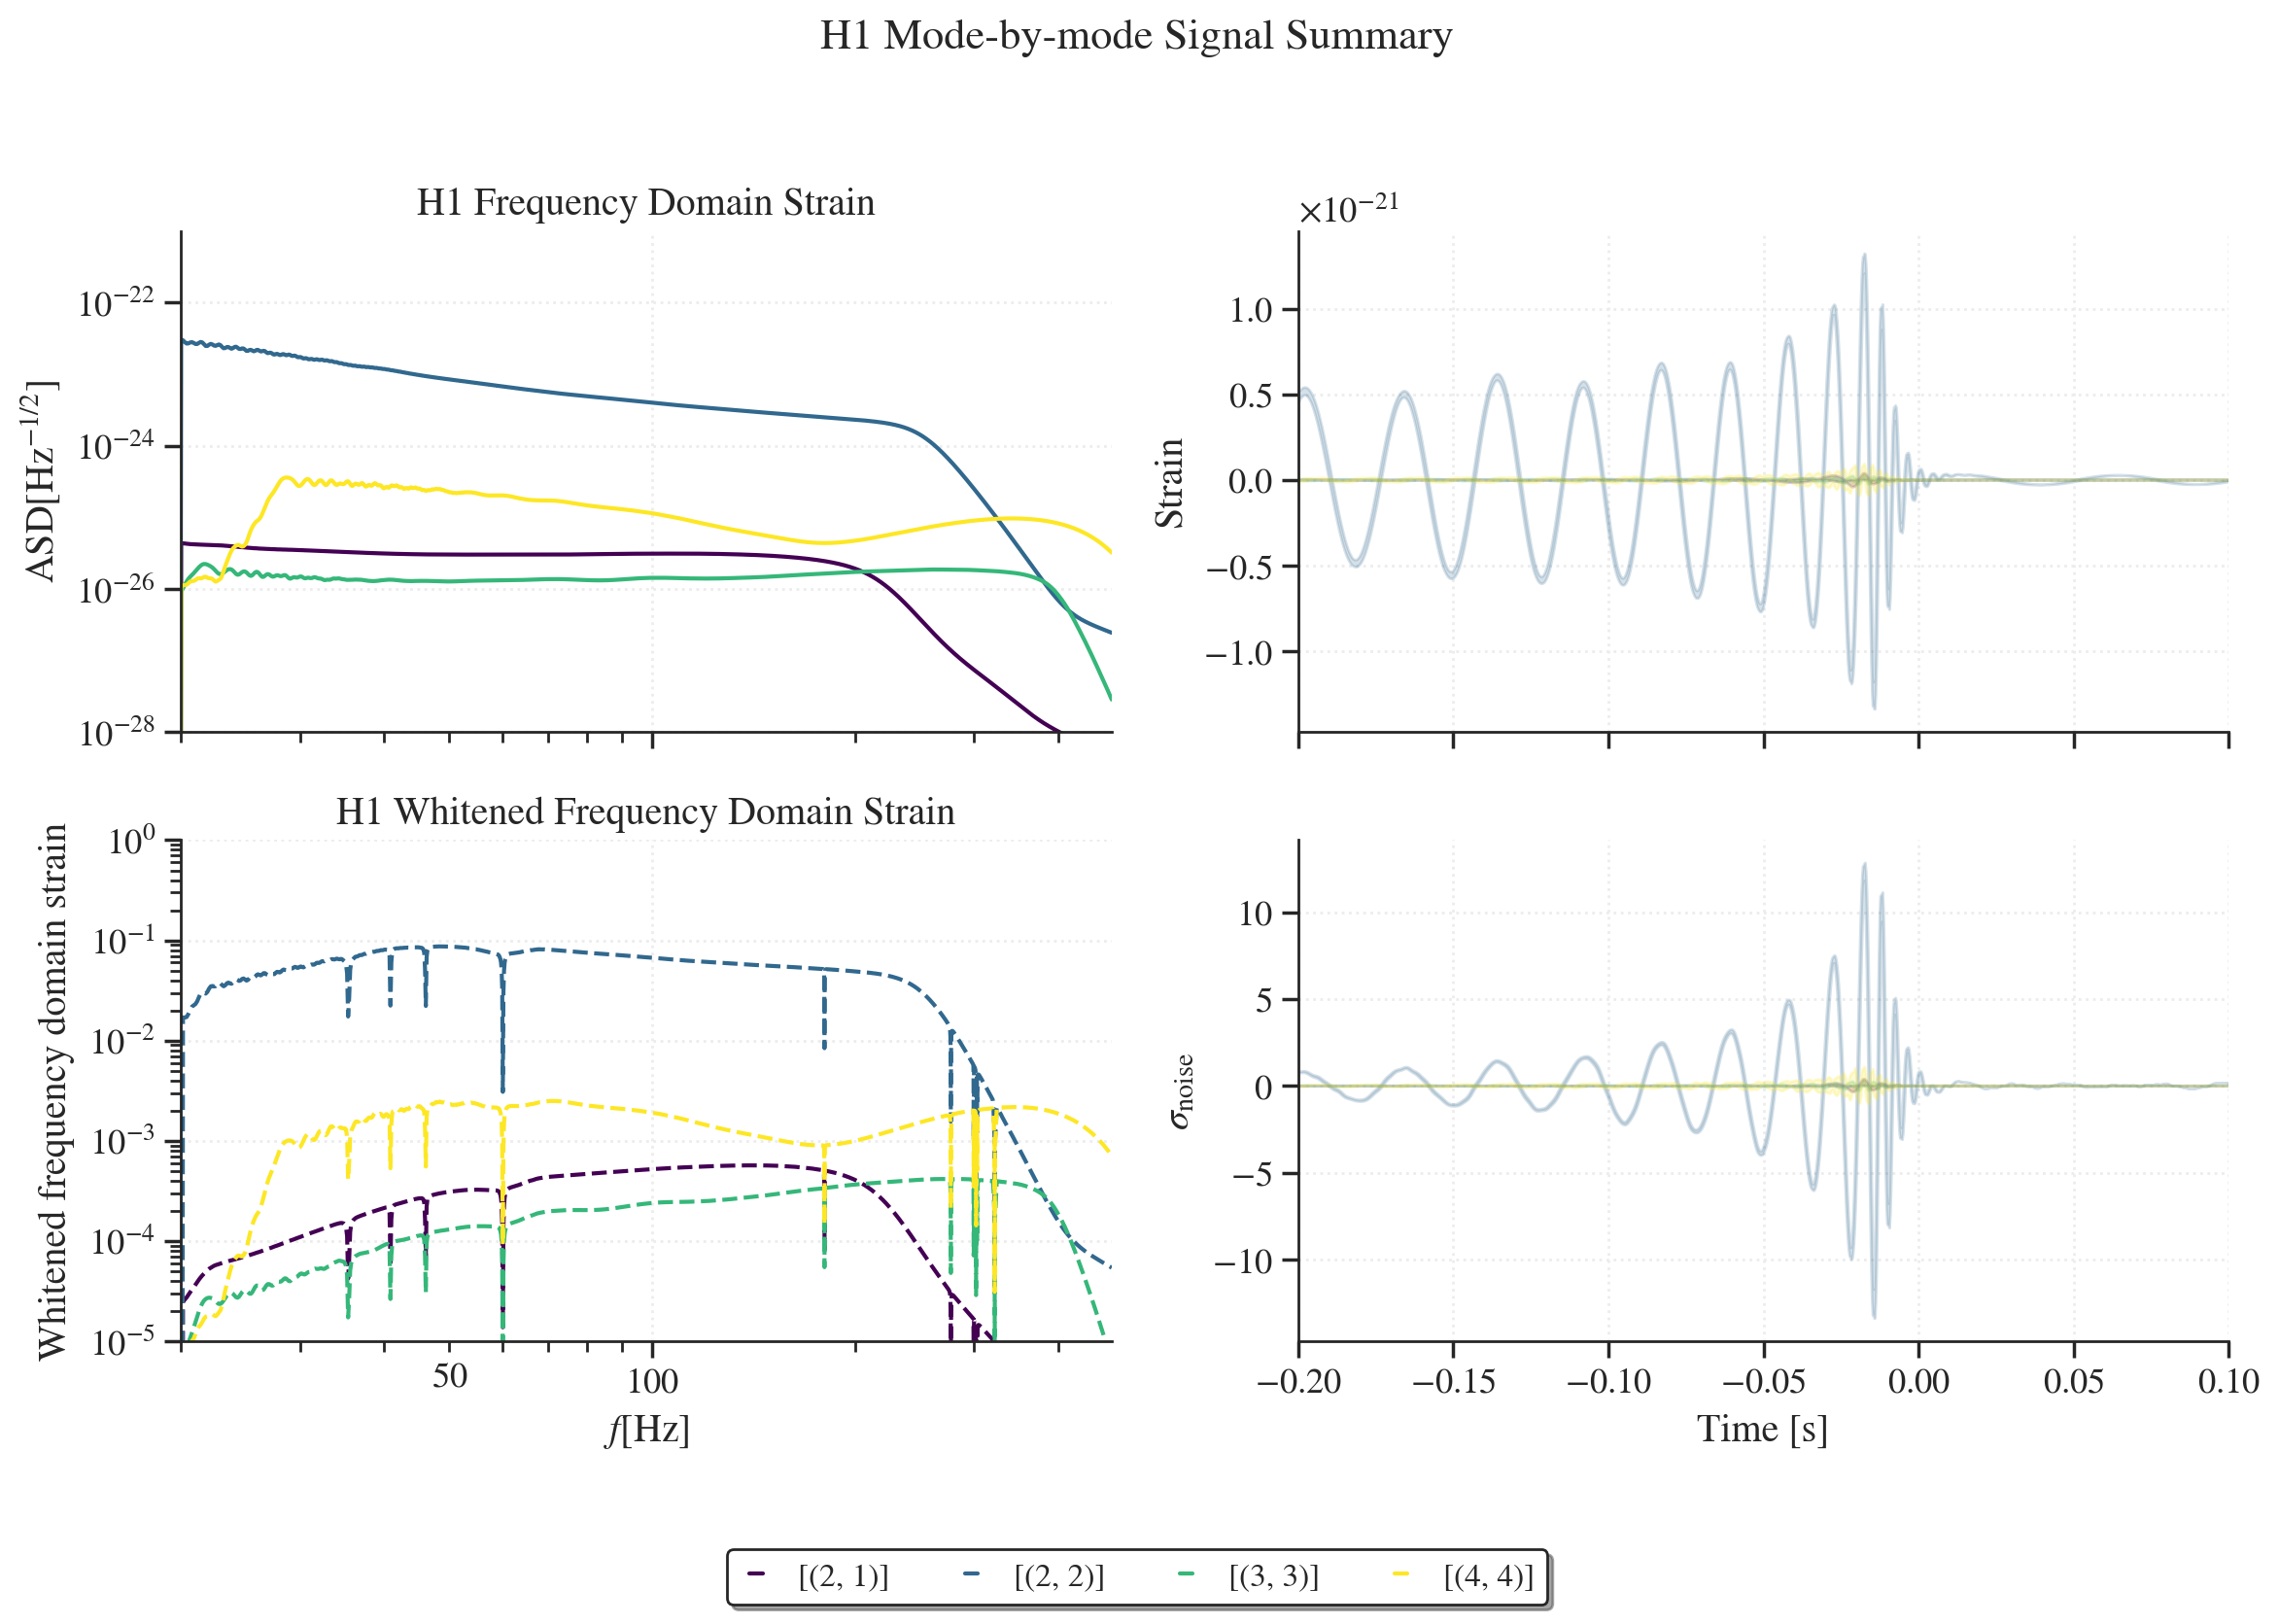

Processing mode: [(2, 1)]
Processing mode: [(2, 2)]
Processing mode: [(3, 3)]
Processing mode: [(4, 4)]


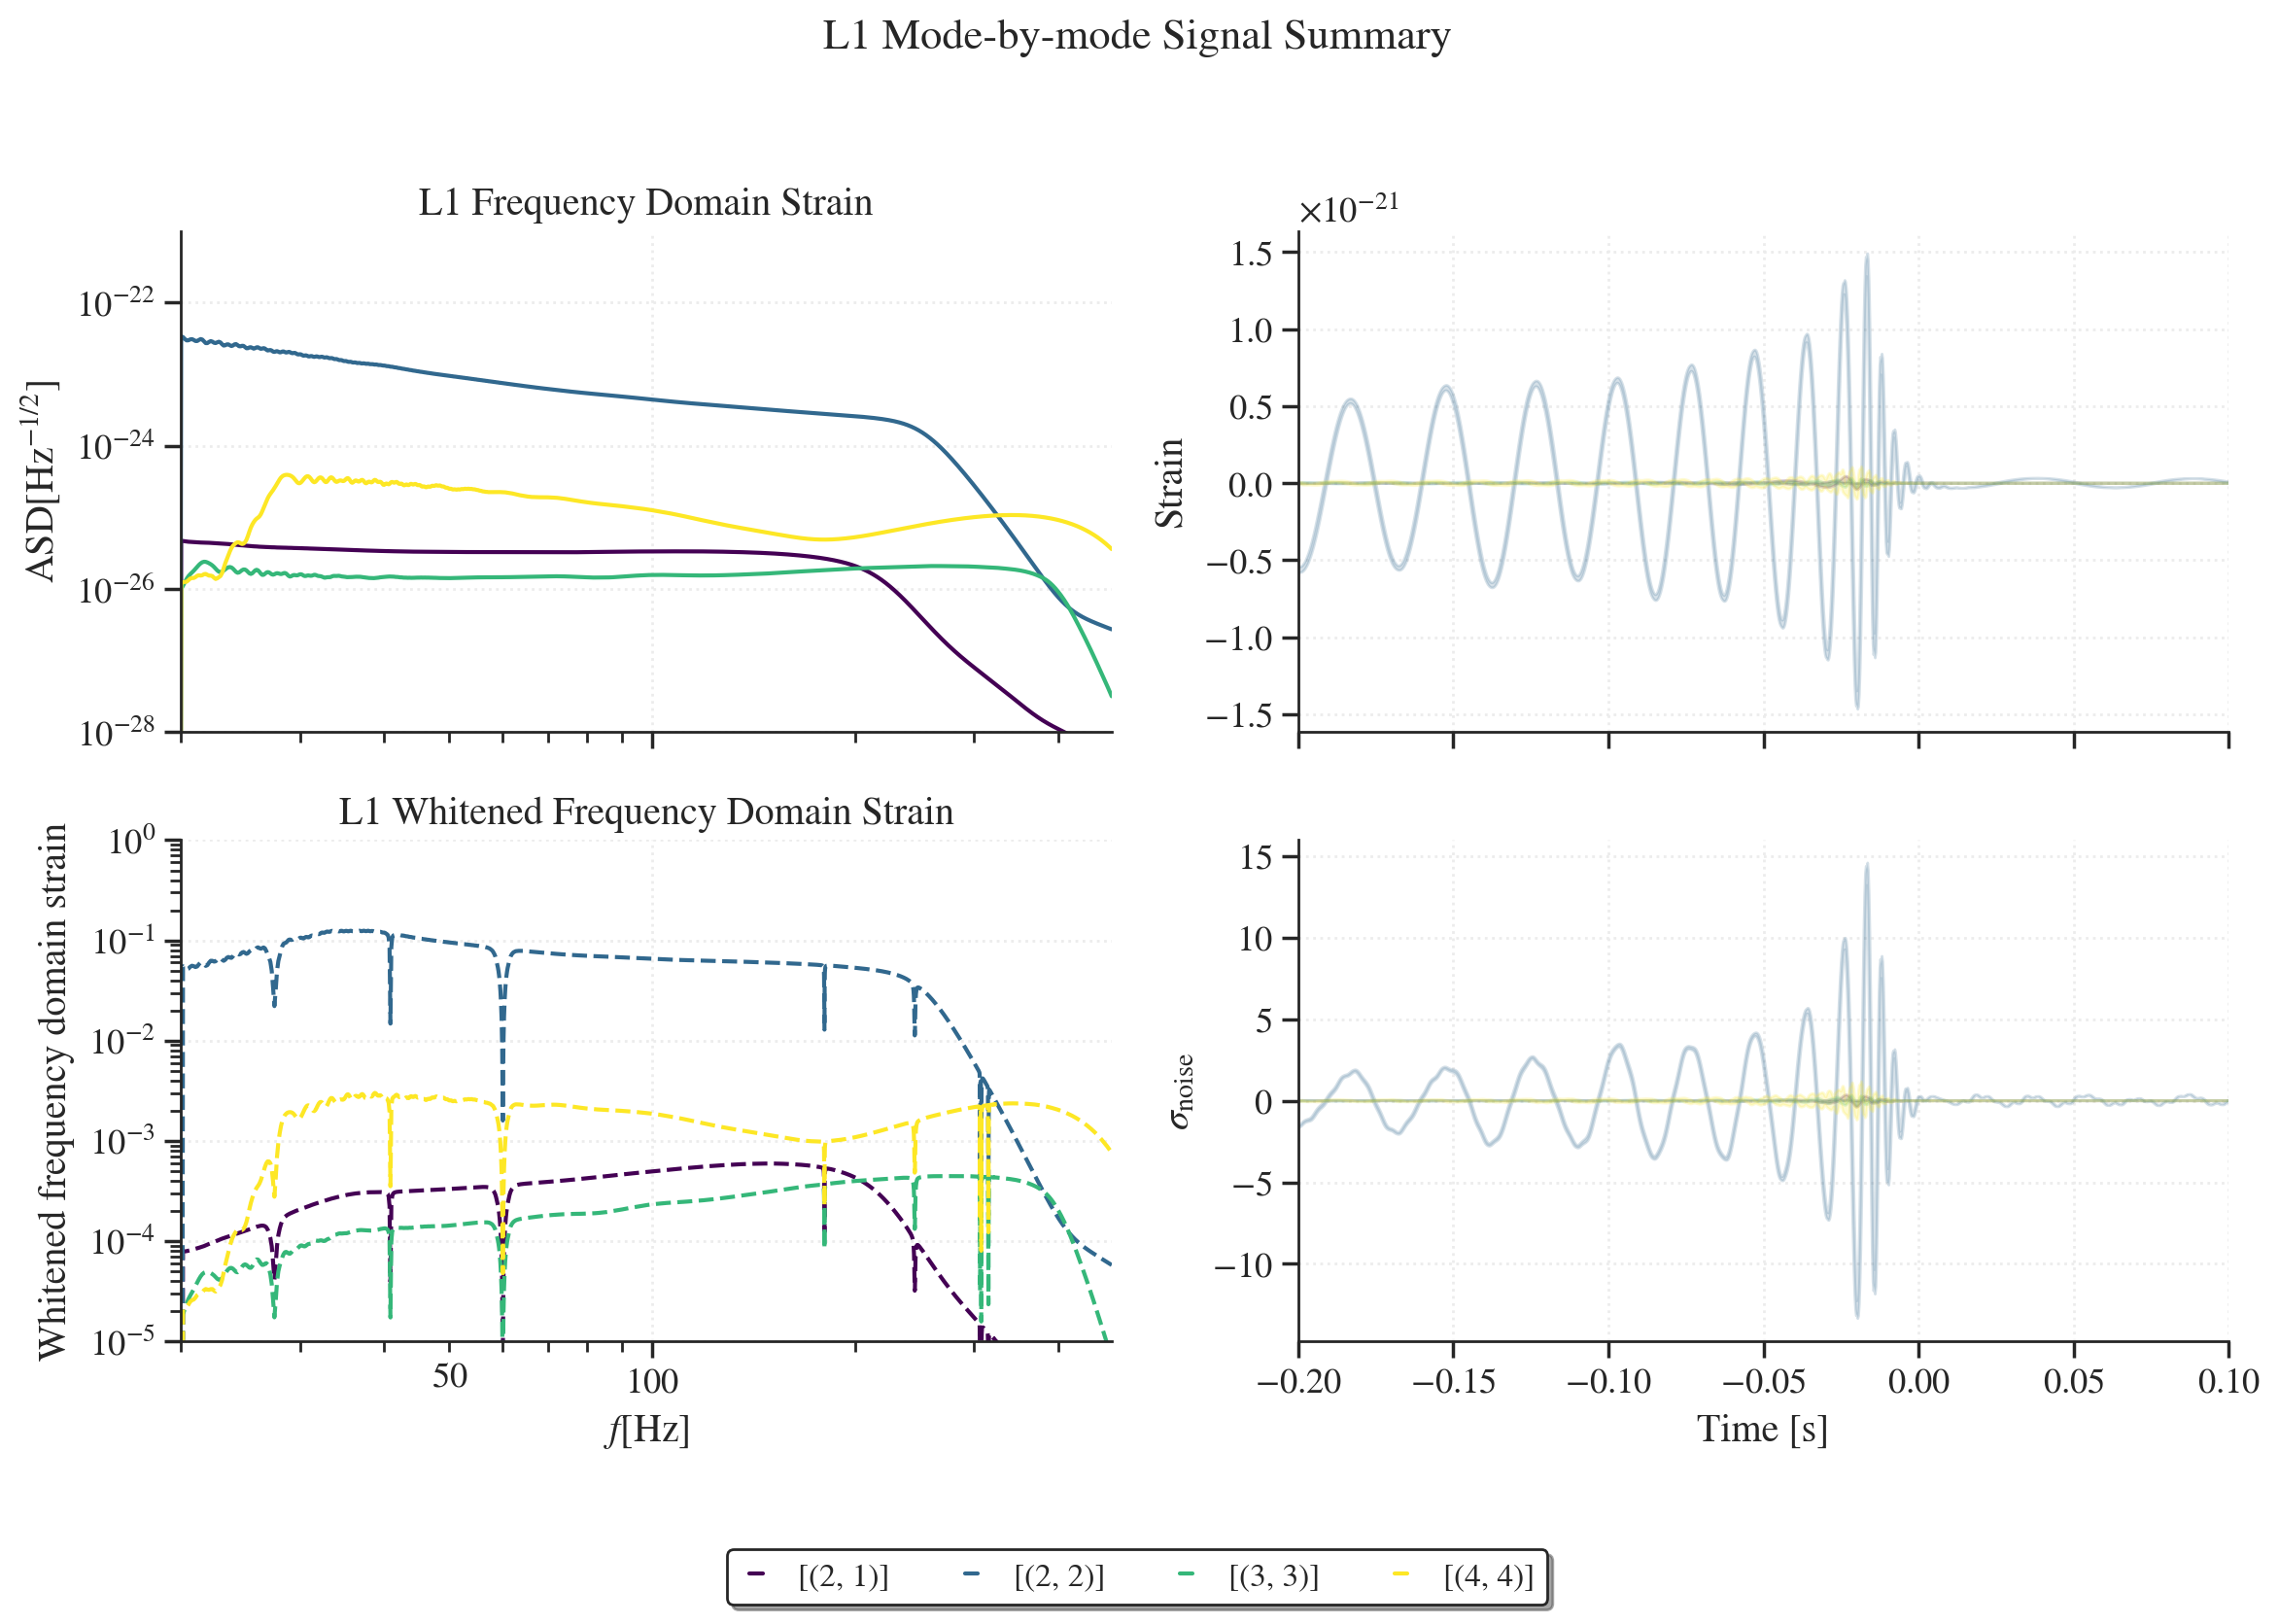

In [30]:
from astropy.constants import G, M_sun, c
import h5py

def asd_from_freq_series(freq_data, df):
    return numpy.abs(freq_data) * (2 * df)**0.5

def abs_freq_series(freq_data):
    return numpy.abs(freq_data)

maxl = numpy.argmax(results.posterior['log_likelihood'])
geocent_time = results.posterior['geocent_time'][maxl]

lower_percentile = 5
upper_percentile = 95

ifo_list = ['H1', 'L1']
with h5py.File('teobresums-aligned-non-eccentric-posterior-waveforms-modes.h5', 'r') as f:
    colors = pylab.cm.viridis(numpy.linspace(0, 1, len(f.keys())))
    for ifo_name in ifo_list:
        fig, axs = pylab.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex='col')

        # already_labeled_peak = False
        # already_labeled_modesum_peak = False

        for color_idx, (mode_key, mode_data) in enumerate(f.items()):
            print(f"Processing mode: {mode_key}")
            freq_array = mode_data["frequency_array"][ifo_name]
            time_array = mode_data["time_array"][ifo_name]
            df = freq_array[1] - freq_array[0]
            # try:
            #     freq_strain = numpy.array(mode_data["frequency_domain_strain"][ifo_name])
            #     whitened_freq_strain = numpy.array(mode_data["whitened_frequency_domain_strain"][ifo_name])

            #     mean_asd = asd_from_freq_series(numpy.mean(numpy.abs(freq_strain), axis=0), df)
            #     lower_asd = asd_from_freq_series(numpy.percentile(numpy.abs(freq_strain), lower_percentile, axis=0), df)
            #     upper_asd = asd_from_freq_series(numpy.percentile(numpy.abs(freq_strain), upper_percentile, axis=0), df)

            #     mean_asd_white = abs_freq_series(numpy.mean(numpy.abs(whitened_freq_strain), axis=0))
            #     lower_asd_white = abs_freq_series(numpy.percentile(numpy.abs(whitened_freq_strain), lower_percentile, axis=0))
            #     upper_asd_white = abs_freq_series(numpy.percentile(numpy.abs(whitened_freq_strain), upper_percentile, axis=0))

            #     axs[0,0].plot(freq_array, mean_asd, label=mode_key, color=colors[color_idx])
            #     axs[0,0].fill_between(freq_array, lower_asd, upper_asd, color=colors[color_idx], alpha=0.2, label=mode_key)

            #     axs[1,0].plot(freq_array, mean_asd_white, label=mode_key, color=colors[color_idx], linestyle='--')
            #     axs[1,0].fill_between(freq_array, lower_asd_white, upper_asd_white, color=colors[color_idx], alpha=0.2, label=mode_key)
            # except:
            time_strain = numpy.array(mode_data["time_domain_strain"][ifo_name])
            whitened_time_strain = numpy.array(mode_data["whitened_time_domain_strain"][ifo_name])
            shifted_time = time_array - geocent_time

            mean_time = numpy.mean(time_strain, axis=0)
            lower_time = numpy.percentile(time_strain, lower_percentile, axis=0)
            upper_time = numpy.percentile(time_strain, upper_percentile, axis=0)

            mean_whitened = numpy.mean(whitened_time_strain, axis=0)
            lower_whitened = numpy.percentile(whitened_time_strain, lower_percentile, axis=0)
            upper_whitened = numpy.percentile(whitened_time_strain, upper_percentile, axis=0)

            freq_strain, frequency_array = bilby.core.utils.series.nfft(mean_time, sampling_frequency=1/(time_array[1] - time_array[0]))
            mean_asd = asd_from_freq_series(freq_strain, df)
            axs[0,0].plot(frequency_array, mean_asd, label=mode_key, color=colors[color_idx])

            freq_strain, frequency_array = bilby.core.utils.series.nfft(lower_time, sampling_frequency=1/(time_array[1] - time_array[0]))
            lower_asd = asd_from_freq_series(freq_strain, df)
            freq_strain, frequency_array = bilby.core.utils.series.nfft(upper_time, sampling_frequency=1/(time_array[1] - time_array[0]))
            upper_asd = asd_from_freq_series(freq_strain, df)
            # axs[0,0].fill_between(frequency_array, lower_asd, upper_asd, color=colors[color_idx], alpha=0.2, label=mode_key)
            axs[0, 0].set_title(f"{ifo_name} Frequency Domain Strain")
            axs[0, 0].set_ylim(1e-28, 1e-21)
            # axs[0,0].set_xlim(20, 480)

                # lower_asd = asd_from_freq_series(bilby.core.utils.series.nfft(lower_time, sampling_frequency=1/(time_array[1] - time_array[0])[0]), df)
                # upper_asd = asd_from_freq_series(bilby.core.utils.series.nfft(upper_time, sampling_frequency=1/(time_array[1] - time_array[0])[0]), df)
                # axs[0,0].fill_between(frequency_array, lower_asd, upper_asd, color=colors[color_idx], alpha=0.2, label=mode_key)
                
            whitened_freq_strain, frequency_array = bilby.core.utils.series.nfft(mean_whitened, sampling_frequency=1/(time_array[1] - time_array[0]))
            mean_asd_white = abs_freq_series(whitened_freq_strain)
            axs[1,0].plot(frequency_array, mean_asd_white, label=mode_key, color=colors[color_idx], linestyle='--')
            
            freq_strain, frequency_array = bilby.core.utils.series.nfft(lower_whitened, sampling_frequency=1/(time_array[1] - time_array[0]))
            lower_asd_white = abs_freq_series(freq_strain)
            freq_strain, frequency_array = bilby.core.utils.series.nfft(upper_whitened, sampling_frequency=1/(time_array[1] - time_array[0]))
            upper_asd_white = abs_freq_series(freq_strain)
            # axs[1,0].fill_between(frequency_array, lower_asd_white, upper_asd_white, color=colors[color_idx], alpha=0.2, label=mode_key)
            axs[1,0].set_title(f"{ifo_name} Whitened Frequency Domain Strain")
            axs[1,0].set_ylim(1e-5, 1)
                # lower_asd_white = abs_freq_series(bilby.core.utils.series.nfft(lower_whitened, sampling_frequency=1/(time_array[1] - time_array[0]))[0])
                # upper_asd_white = abs_freq_series(bilby.core.utils.series.nfft(upper_whitened, sampling_frequency=1/(time_array[1] - time_array[0]))[0])
                # axs[1,0].fill_between(frequency_array, lower_asd_white, upper_asd_white, color=colors[color_idx], alpha=0.2, label=mode_key)
            # Plot time domain strain


            time_strain = numpy.array(mode_data["time_domain_strain"][ifo_name])
            whitened_time_strain = numpy.array(mode_data["whitened_time_domain_strain"][ifo_name])
            shifted_time = time_array - geocent_time

            mean_time = numpy.mean(time_strain, axis=0)
            lower_time = numpy.percentile(time_strain, lower_percentile, axis=0)
            upper_time = numpy.percentile(time_strain, upper_percentile, axis=0)

            mean_whitened = numpy.mean(whitened_time_strain, axis=0)
            lower_whitened = numpy.percentile(whitened_time_strain, lower_percentile, axis=0)
            upper_whitened = numpy.percentile(whitened_time_strain, upper_percentile, axis=0)

            # axs[0][1].plot(shifted_time, mean_time, label=mode_key, color=colors[color_idx])
            axs[0][1].fill_between(shifted_time, lower_time, upper_time, color=colors[color_idx], alpha=0.2)
            # axs[1][1].plot(shifted_time, mean_whitened, label=mode_key, color=colors[color_idx], linestyle='--')
            axs[1][1].fill_between(shifted_time, lower_whitened, upper_whitened, color=colors[color_idx], alpha=0.2)

            # Add vertical lines only once with label
            # if not already_labeled_peak:
            #     axs[0][1].axvline(t_peak[ifo_name] - geocent_time, color='#ca2000', linestyle='-', label=r'$t_{\mathrm{peak}}^{|h_+ - i h_\times|^2}$')
            #     axs[1][1].axvline(t_peak[ifo_name] - geocent_time, color='#ca2000', linestyle='-')
            #     already_labeled_peak = True
            # else:
            #     axs[0][1].axvline(t_peak[ifo_name] - geocent_time, color='#ca2000', linestyle='-')
            #     axs[1][1].axvline(t_peak[ifo_name] - geocent_time, color='#ca2000', linestyle='-')


        # Axis formatting
        axs[1][0].set_xlabel("$f [\\mathrm{Hz}]$")
        axs[1][1].set_xlabel("Time [s]")
        axs[0][0].set_ylabel("$\\mathrm{ASD} \\left[\\mathrm{Hz}^{-1/2}\\right]$")
        axs[1][0].set_ylabel(r"Whitened frequency domain strain")
        axs[0][1].set_ylabel(r"Strain")
        axs[1][1].set_ylabel(r"$\sigma_\mathrm{noise}$")

        for ax in axs[:, 0]:
            ax.set_yscale("log")
            ax.set_xscale("log")
            ax.set_xlim(20, 480)
            ax.grid(True)

        for ax in axs[:, 1]:
            ax.set_xlim(-0.2, 0.1)
            ax.grid(True)

        # --- Collect legend entries ---
        handles, labels = [], []
        for ax in axs.flatten():
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)

        # Remove duplicates while preserving order
        seen = set()
        unique = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]

        # Create a common legend
        fig.legend(*zip(*unique), fontsize=12, loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

        fig.suptitle(fr"{ifo_name} Mode-by-mode Signal Summary", fontsize=16)
        pylab.tight_layout(rect=[0, 0.03, 1, 0.95])
        sns.despine()
        pylab.show()


[(4, 4)]
Processing mode: [(4, 4)]
[(4, 4)]
Processing mode: [(4, 4)]


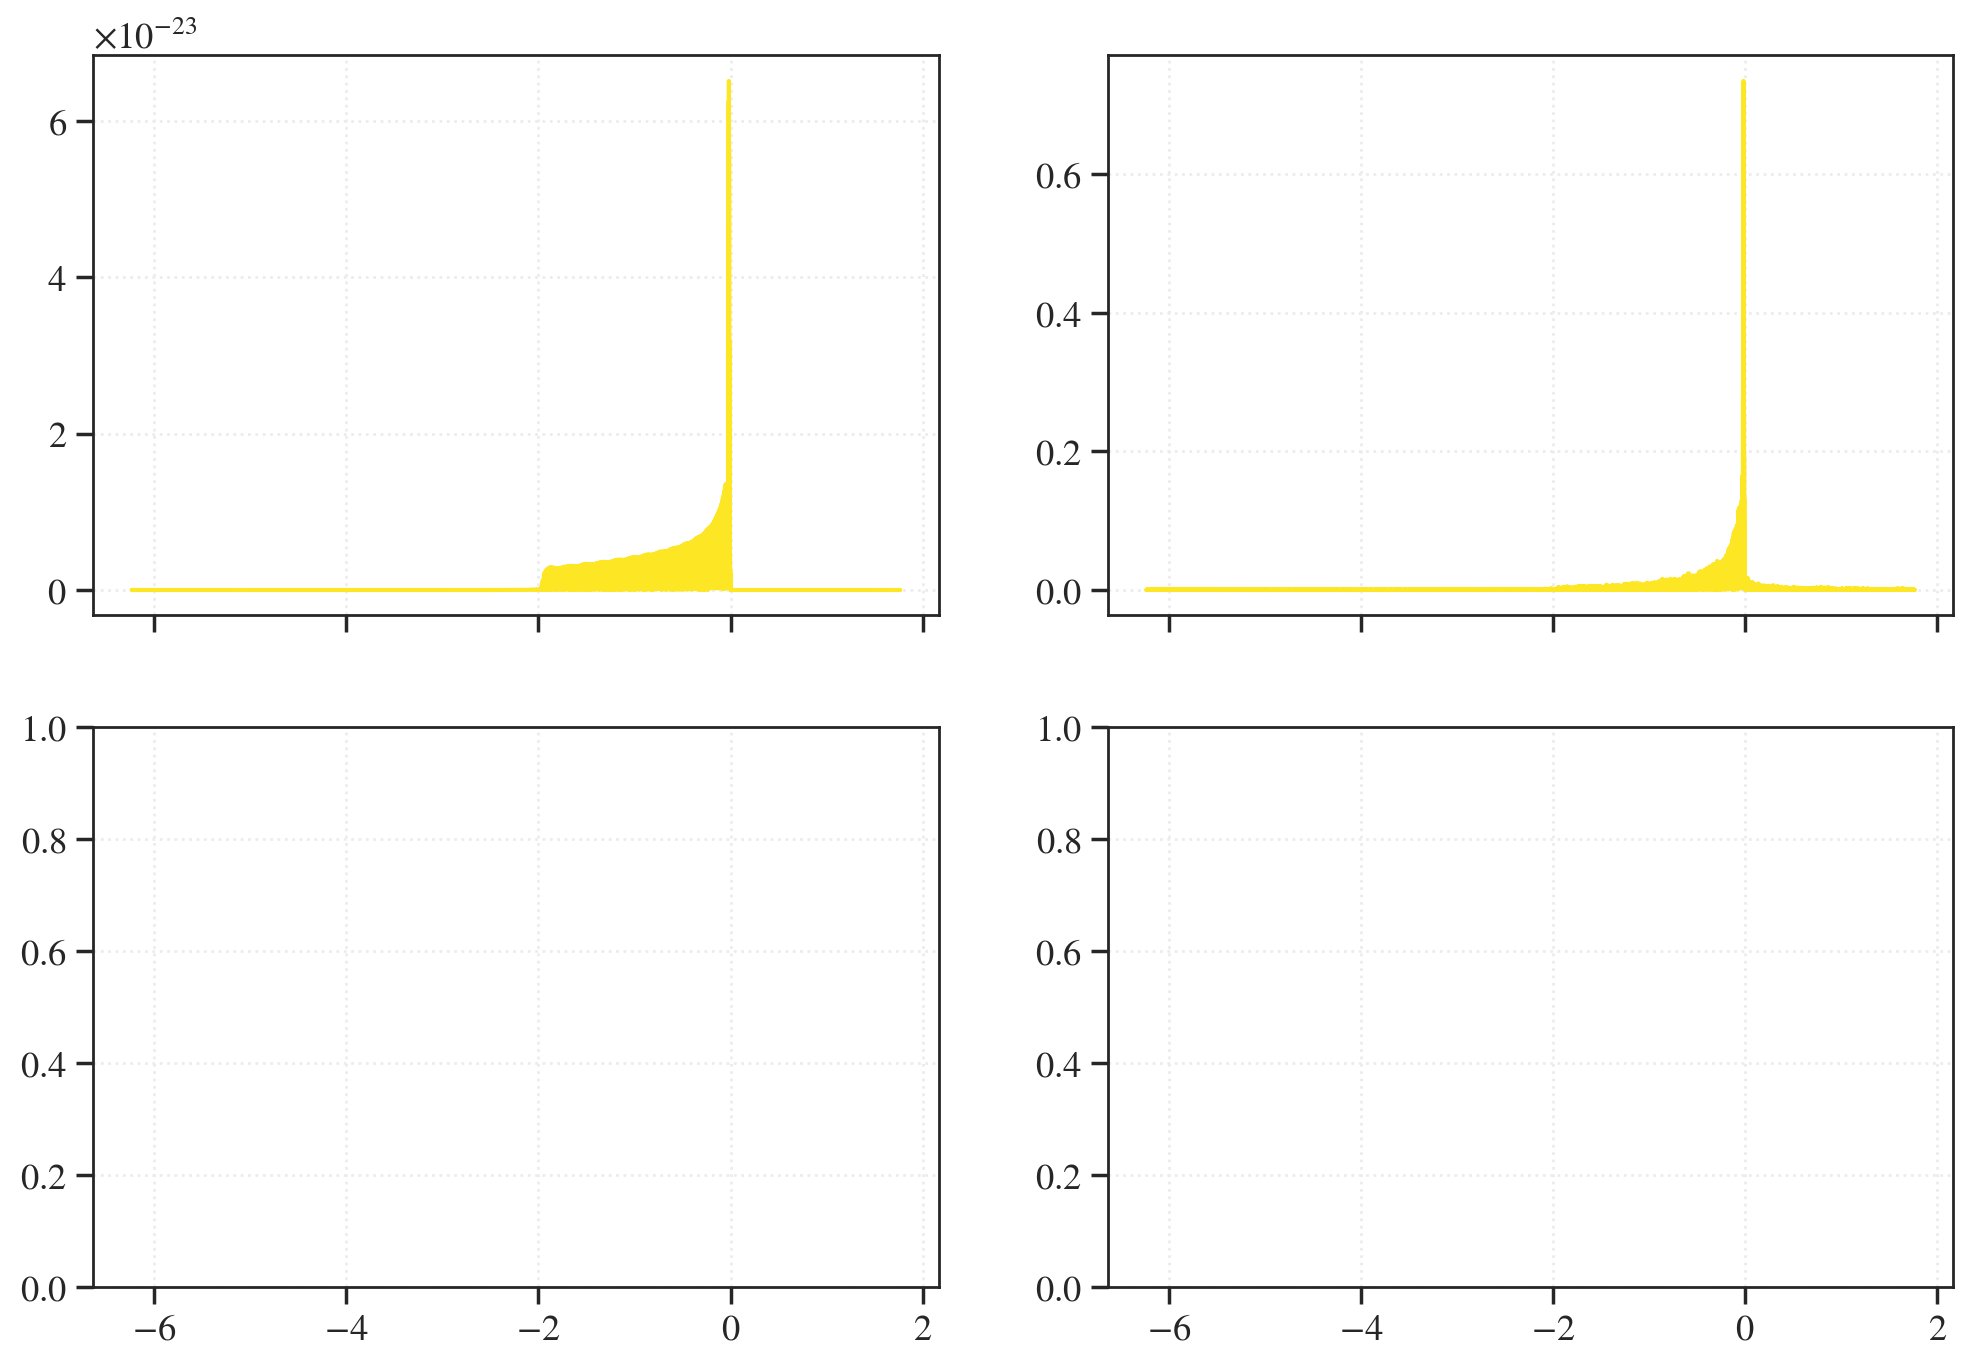

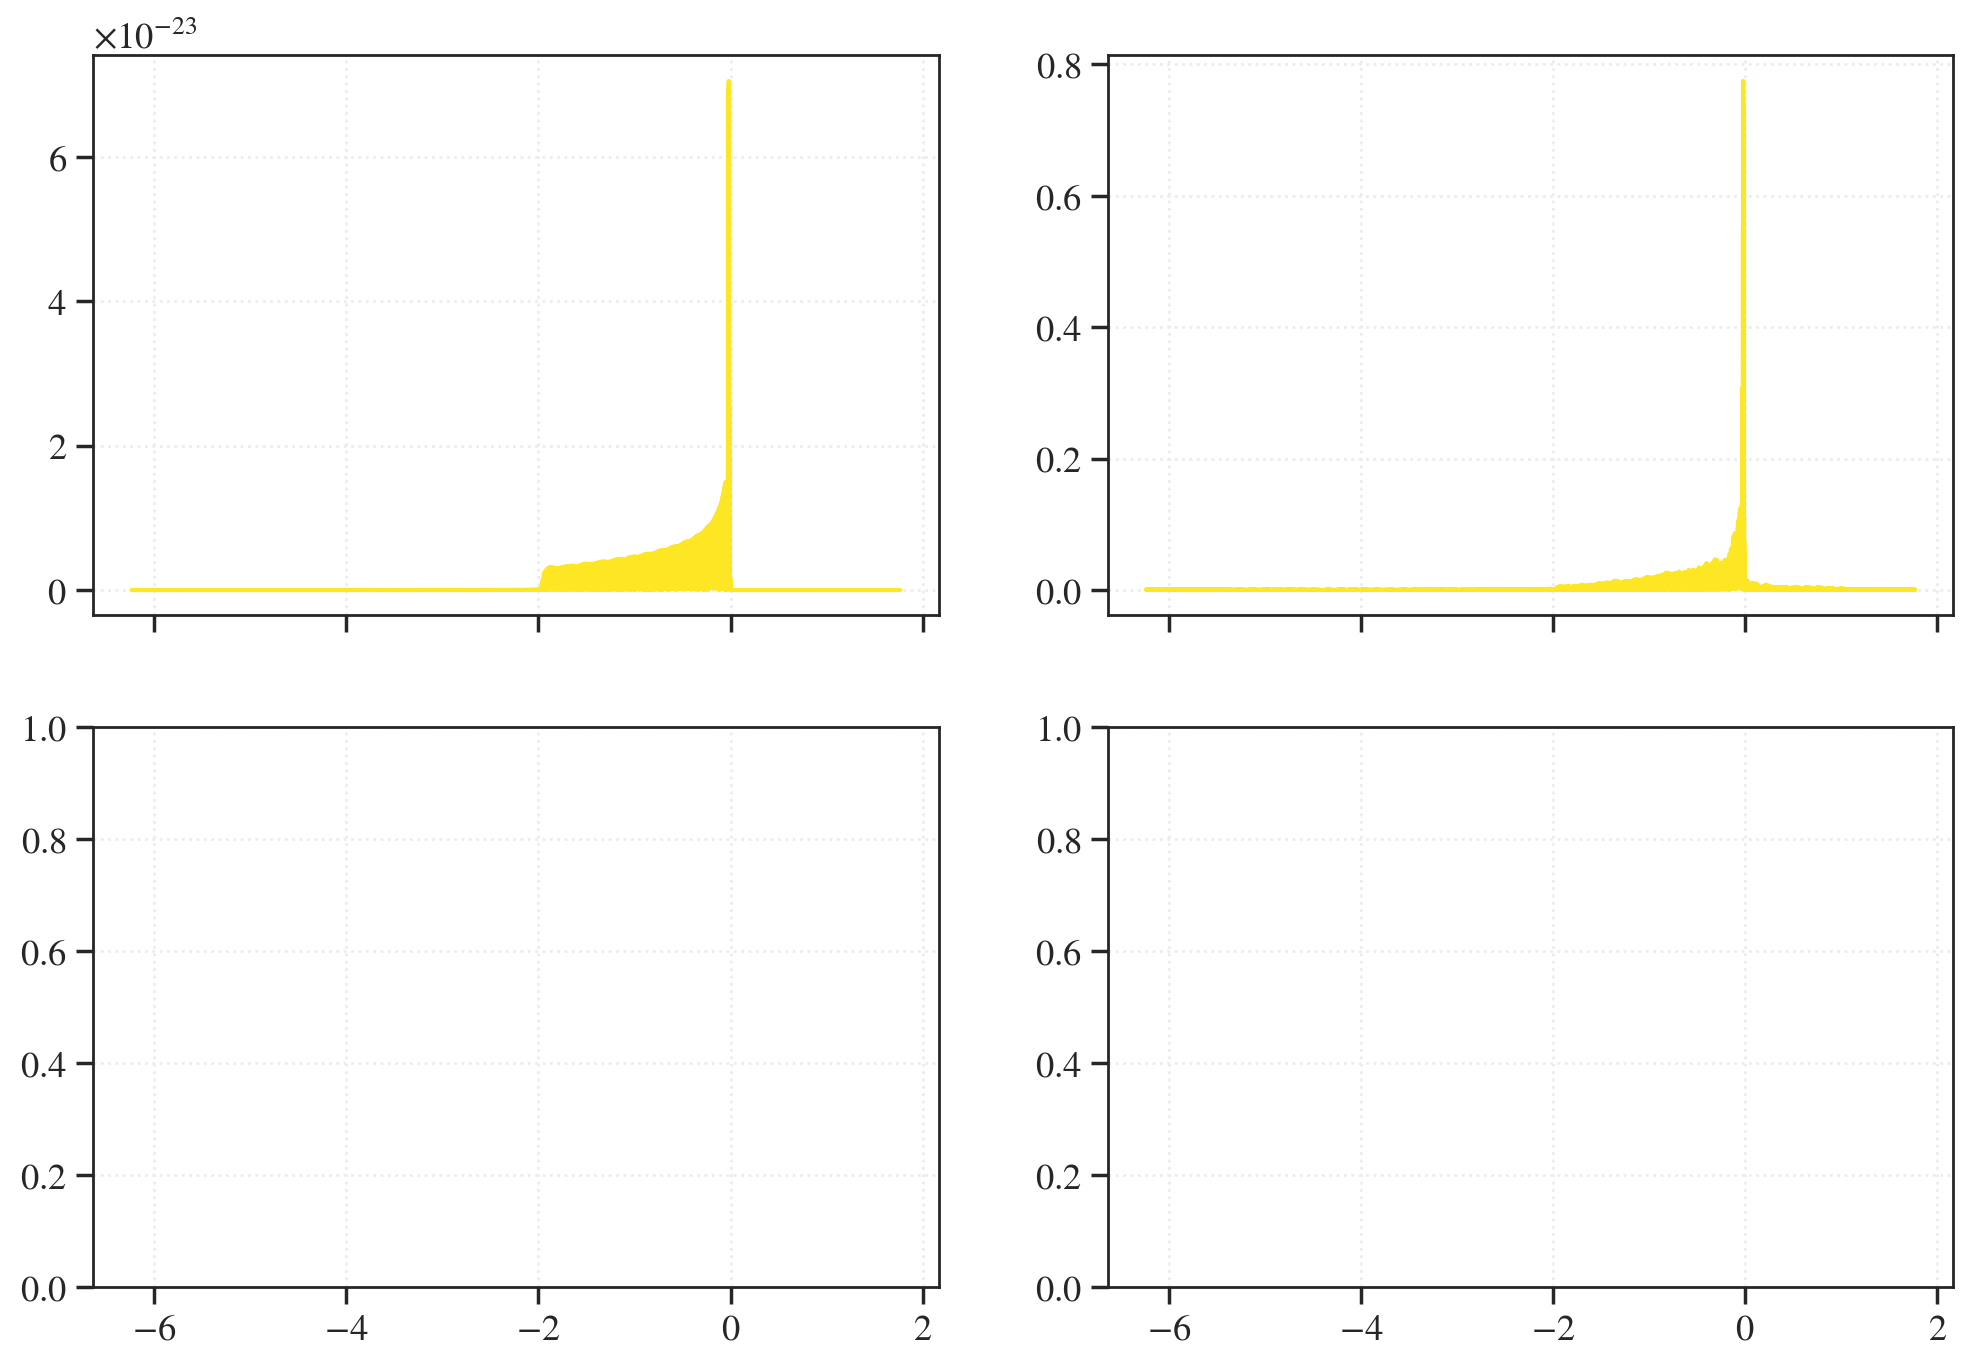

In [42]:

with h5py.File('teobresums-aligned-non-eccentric-posterior-waveforms-modes.h5', 'r') as f:
    colors = pylab.cm.viridis(numpy.linspace(0, 1, len(f.keys())))
    for ifo_name in ifo_list:
        fig, axs = pylab.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex='col')

        # already_labeled_peak = False
        # already_labeled_modesum_peak = False

        for color_idx, (mode_key, mode_data) in enumerate(f.items()):
            if mode_key != "[(4, 4)]":
                continue  # Skip everything that's not (4, 4)

            print(mode_key)
            print(f"Processing mode: {mode_key}")
            freq_array = mode_data["frequency_array"][ifo_name]
            time_array = mode_data["time_array"][ifo_name]
            df = freq_array[1] - freq_array[0]
            time_strain = numpy.array(mode_data["time_domain_strain"][ifo_name])
            whitened_time_strain = numpy.array(mode_data["whitened_time_domain_strain"][ifo_name])
            shifted_time = time_array - geocent_time

            mean_time = numpy.mean(time_strain, axis=0)
            mean_whitened = numpy.mean(whitened_time_strain, axis=0)

            axs[0][0].plot(shifted_time, numpy.abs(mean_time), label=mode_key, color=colors[color_idx])
            axs[0][1].plot(shifted_time, numpy.abs(mean_whitened), label=mode_key, color=colors[color_idx])
